In [1]:
import logging
import os

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
WORLD_SIZE = int(os.environ.get("WORLD_SIZE", 1))
DATA_URL = './all_stocks_5yr.csv'
COMPANY_NAME = 'AAPL'
FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']
TARGET_COL = 'close'
LAG = 14
EPOCHS = 300
LR = 1e-3
NO_CUDA = False
SEED = 42
LOG_PATH = ''

In [3]:
df = pd.read_csv(DATA_URL)
df.groupby('Name').close.mean().sort_values()

Name
AMD         5.601863
HBAN       10.621372
RF         10.935608
AES        12.340048
CHK        13.681326
            ...     
AMZN      576.880041
AZO       619.703654
GOOGL     682.233847
GOOG      725.403353
PCLN     1312.873538
Name: close, Length: 505, dtype: float64

In [4]:
df[df.Name == 'AMD']

,date,open,high,low,close,volume,Name
38833,2013-02-08,2.580,2.60,2.58,2.59,5971768,AMD
38834,2013-02-11,2.590,2.70,2.59,2.67,22410941,AMD
38835,2013-02-12,2.705,2.78,2.69,2.77,13675442,AMD
38836,2013-02-13,2.810,2.83,2.73,2.75,11481985,AMD
38837,2013-02-14,2.740,2.75,2.69,2.75,13283766,AMD
...,...,...,...,...,...,...,...
40087,2018-02-01,13.620,13.84,13.21,13.25,67543333,AMD
40088,2018-02-02,13.050,13.06,12.43,12.45,79432558,AMD
40089,2018-02-05,12.050,12.18,10.93,11.57,116568862,AMD
40090,2018-02-06,11.040,11.74,11.00,11.65,87123202,AMD


## Utils

In [5]:
def should_distribute():
    return dist.is_available() and WORLD_SIZE > 1


def is_distributed():
    return dist.is_available() and dist.is_initialized()

## Dataset

In [6]:
def get_data(name, url=DATA_URL):
    df = pd.read_csv(url)
    df = df[df['Name'] == name]
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    targets = df[TARGET_COL].values
    features = df[FEATURE_COLS].values

#     feature_scaler = MinMaxScaler()
#     target_scaler = MinMaxScaler()
#     features = feature_scaler.fit_transform(features) # Scale the data
#     targets = target_scaler.fit_transform(targets.reshape(-1, 1)).squeeze()
    train_size = int(0.8 * len(features))
    X_train, X_test, y_train, y_test = features[:train_size], features[train_size:], targets[:train_size], targets[train_size:]
    
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
    y_test = target_scaler.transform(y_test.reshape(-1, 1)).squeeze()
    
    return X_train, X_test, y_train, y_test, target_scaler


def process_data(features, targets, lag):
    X, Y = [], []
    lag = lag
    for i in range(len(features) - lag - 1):
        X.append(features[i: (i + lag)])
        Y.append(targets[(i + lag)])
    return np.array(X), np.array(Y)


# class StockDataset(Dataset):
#     def __init__(self, X, y, train=True, test_size=0.2):
#         super(StockDataset, self).__init__()
#         cutoff = int((1-test_size) * len(X))
#         if train:
#             self.features = X[:cutoff]
#             self.targets = y[:cutoff]
#         else:
#             self.features = X[cutoff:]
#             self.targets = y[cutoff:]

#         self.features = self.features.astype(np.float32)
#         self.targets = self.targets.astype(np.float32)

#     def __len__(self):
#         assert len(self.features) == len(self.targets)
#         return len(self.features)

#     def __getitem__(self, item):
#         return self.features[item], self.targets[item]

## RNN model

In [7]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size, dropout=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.num_directions = bidirectional + 1
        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)

#         hidden_size = hidden_state[-1].size(-1)
        r_out = r_out[:, -1, :]
        outs = self.out(r_out)

        return outs, hidden_state

## Training function

In [8]:
def train(X_train, y_train, model, device, optimizer, loss_fn, epoch):
    model.train()
    
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    optimizer.zero_grad()
    output, _ = model(X_train, None)
    loss = loss_fn(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        msg = "Train Epoch: {}\tloss={}".format(
            epoch, loss.item())
        logging.info(msg)
    
    return loss.item()

## Test function

In [9]:
def test(X_test, y_test, model, device, loss_fn, epoch):
    model.eval()
    with torch.no_grad():
        X_test = torch.from_numpy(X_test).float().to(device)
        y_test = torch.from_numpy(y_test).float().to(device)
        output, _ = model(X_test, None)
        test_loss = loss_fn(output.squeeze(), y_test)

    if epoch % 10 == 0:
        logging.info("{{metricName: loss, metricValue: {}}}\n".format(test_loss))
    
    return test_loss.item()

## Main function

In [10]:
def main():
    if dist.is_available():
        BACKEND = dist.Backend.GLOO

    # Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
    # If log_path is empty print log to StdOut, otherwise print log to the file.
    if LOG_PATH == "":
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.DEBUG)
    else:
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.DEBUG,
            filename=LOG_PATH)

    use_cuda = not NO_CUDA and torch.cuda.is_available()
    if use_cuda:
        print("Using CUDA")

    torch.manual_seed(SEED)

    device = torch.device("cuda" if use_cuda else "cpu")

    if should_distribute():
        print("Using distributed PyTorch with {} backend".format(BACKEND))
        dist.init_process_group(backend=BACKEND)

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    X_train, X_test, y_train, y_test, target_scaler = get_data(name=COMPANY_NAME)
    X_train, y_train = process_data(X_train, y_train, LAG)
    X_test, y_test = process_data(X_test, y_test, LAG)

    model = RNN(i_size=5,
                h_size=64,
                n_layers=3,
                o_size=1,
                bidirectional=False,
                )
    model.to(device)

    if is_distributed():
        Distributor = nn.parallel.DistributedDataParallel if use_cuda \
            else nn.parallel.DistributedDataParallelCPU
        model = Distributor(model)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    for epoch in range(1, EPOCHS + 1):
        train(X_train, y_train, model, device, optimizer, loss_fn, epoch)
        test(X_test, y_test, model, device, loss_fn, epoch)

In [11]:
# main()

In [12]:
if dist.is_available():
    BACKEND = dist.Backend.GLOO

# Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
# If log_path is empty print log to StdOut, otherwise print log to the file.
if LOG_PATH == "":
    logging.basicConfig(
        format="%(asctime)s %(levelname)-8s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%SZ",
        level=logging.DEBUG)
else:
    logging.basicConfig(
        format="%(asctime)s %(levelname)-8s %(message)s",
        datefmt="%Y-%m-%dT%H:%M:%SZ",
        level=logging.DEBUG,
        filename=LOG_PATH)

use_cuda = not NO_CUDA and torch.cuda.is_available()
if use_cuda:
    print("Using CUDA")

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

if should_distribute():
    print("Using distributed PyTorch with {} backend".format(BACKEND))
    dist.init_process_group(backend=BACKEND)

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

X_train, X_test, y_train, y_test, target_scaler = get_data(name=COMPANY_NAME)
X_train, y_train = process_data(X_train, y_train, LAG)
X_test, y_test = process_data(X_test, y_test, LAG)

model = RNN(i_size=5,
            h_size=64,
            n_layers=3,
            o_size=1,
            bidirectional=False,
            )
model.to(device)

if is_distributed():
    Distributor = nn.parallel.DistributedDataParallel if use_cuda \
        else nn.parallel.DistributedDataParallelCPU
    model = Distributor(model)

optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

for epoch in range(1, EPOCHS + 1):
    train(X_train, y_train, model, device, optimizer, loss_fn, epoch)
    test(X_test, y_test, model, device, loss_fn, epoch)

2021-10-26T19:25:48Z INFO     Train Epoch: 10	loss=0.1672079861164093
2021-10-26T19:25:48Z INFO     {metricName: loss, metricValue: 0.9479496479034424}

2021-10-26T19:25:53Z INFO     Train Epoch: 20	loss=0.05088049918413162
2021-10-26T19:25:53Z INFO     {metricName: loss, metricValue: 0.34427687525749207}

2021-10-26T19:25:56Z INFO     Train Epoch: 30	loss=0.04091815650463104
2021-10-26T19:25:56Z INFO     {metricName: loss, metricValue: 0.32466813921928406}

2021-10-26T19:25:58Z INFO     Train Epoch: 40	loss=0.017282938584685326
2021-10-26T19:25:59Z INFO     {metricName: loss, metricValue: 0.1162271723151207}

2021-10-26T19:26:01Z INFO     Train Epoch: 50	loss=0.005342695862054825
2021-10-26T19:26:01Z INFO     {metricName: loss, metricValue: 0.03256390243768692}

2021-10-26T19:26:04Z INFO     Train Epoch: 60	loss=0.003914440516382456
2021-10-26T19:26:04Z INFO     {metricName: loss, metricValue: 0.04226164147257805}

2021-10-26T19:26:07Z INFO     Train Epoch: 70	loss=0.00282057304866611

In [13]:
features.shape

NameError: name 'features' is not defined

In [ ]:
targets.shape

In [ ]:
out.shape

In [ ]:
X_test.shape

In [21]:
model.eval()
X_test_t = torch.from_numpy(X_test).float().to(device)
out, _ = model(X_test_t, None)
out = out.detach().cpu().numpy()

In [15]:
y_test.shape

(237,)

In [16]:
out.shape

(237, 1)

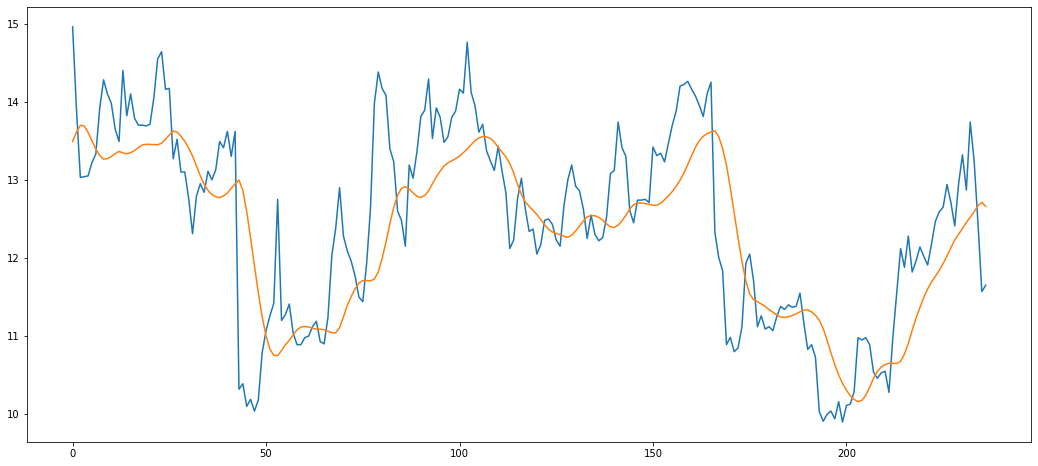

In [22]:
plt.figure(figsize=(18, 8))
plt.plot(target_scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(target_scaler.inverse_transform(out.reshape(-1, 1)))
# plt.plot(targets)
# plt.plot(out)
# plt.ylim((0, 250))

In [20]:
X_train, X_test, y_train, y_test, target_scaler = get_data(name='AMD')
X_train, y_train = process_data(X_train, y_train, LAG)
X_test, y_test = process_data(X_test, y_test, LAG)

In [19]:

plt.plot(train_loss)
plt.plot(test_loss)


NameError: name 'train_loss' is not defined